In [1]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd 

In [14]:
parser = Sbopen()
df_match = parser.match(competition_id=43, season_id=3)
team = "France"

match_ids= df_match.loc[(df_match['home_team_name'] == team) | (df_match['away_team_name'] == team)]['match_id'].to_list()
no_games = len(match_ids)

In [15]:
match_ids

[7546, 7580, 7530, 8649, 8658, 8655, 7563]

In [17]:
danger_passes = pd.DataFrame()
for idx in match_ids:
    df = parser.event(idx)[0]
    for period in [1,2]:

        mask_pass = (df.team_name == team ) & (df.type_name == 'Pass') &(df.outcome_name.isnull()) &(df.period == period) & (df.sub_type_name.isnull())
        passes = df.loc[mask_pass,['x','y','end_x','end_y','minute','second','player_name']]
        mask_shot = (df.team_name == team ) & (df.type_name == "Shot") &(df.period == period)

        shots = df.loc[mask_shot,["minute","second"]]

        shot_times = shots['minute']+ 60+shots['second']
        shot_window = 15
        shot_start = shot_times-shot_window

        shot_start = shot_start.apply(lambda i : i if i<0 else (period-1)*45)
        pass_times = passes['minute']*60+passes['second']
        pass_to_shot = pass_times.apply (lambda x: True in (( shot_start < x) & (x<shot_times)).unique())

        danger_passes_period = passes.loc[pass_to_shot]
        danger_passes=pd.concat([danger_passes,danger_passes_period], ignore_index=True)

In [21]:
danger_passes

,x,y,end_x,end_y,minute,second,player_name
0,32.0,67.0,32.0,23.0,0,16,Raphaël Varane
1,35.0,24.0,37.0,56.0,0,20,Samuel Yves Umtiti
2,45.0,62.0,70.0,77.0,0,24,Raphaël Varane
3,70.0,77.0,49.0,75.0,0,25,Antoine Griezmann
4,49.0,74.0,54.0,61.0,0,27,Benjamin Pavard
...,...,...,...,...,...,...,...
123,70.0,70.0,65.0,79.0,1,25,N''Golo Kanté
124,66.0,79.0,79.0,73.0,1,27,Djibril Sidibé
125,79.0,78.0,89.0,79.0,1,28,Antoine Griezmann
126,85.0,77.0,88.0,79.0,1,37,Ousmane Dembélé


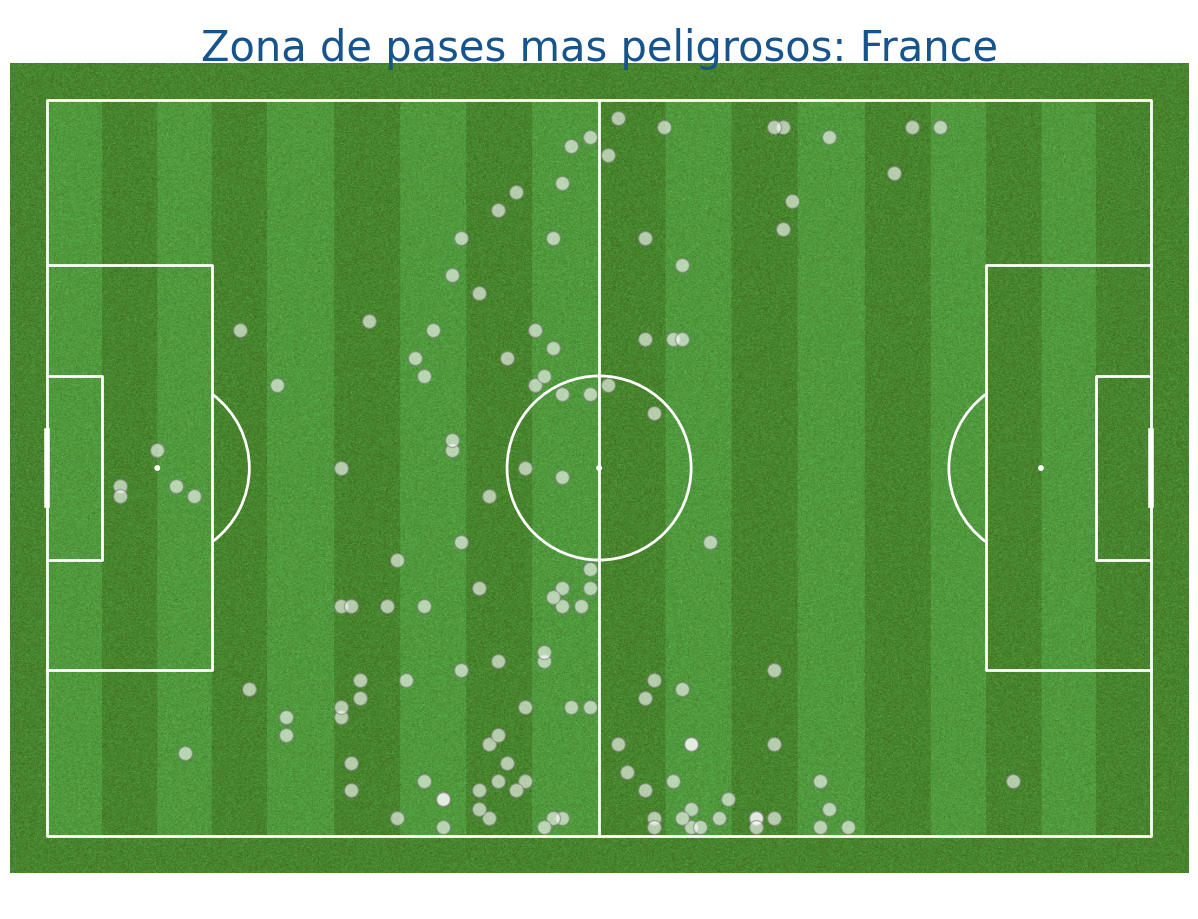

In [31]:
pitch = Pitch(line_color='white',pitch_color='grass', stripe = True)
fig , ax = pitch.grid(grid_height=0.9, title_height=0.06,axis=False,
                     endnote_height=0.04,title_space=0,endnote_space=0)

pitch.scatter(danger_passes.x, danger_passes.y, s=100, color = '#FFFFFF',edgecolors = 'grey', linewidth = 1 , alpha = .6 ,ax=ax['pitch'])
fig.suptitle('Zona de pases mas peligrosos: ' + team , fontsize = 30, c='#17548C')
plt.show()

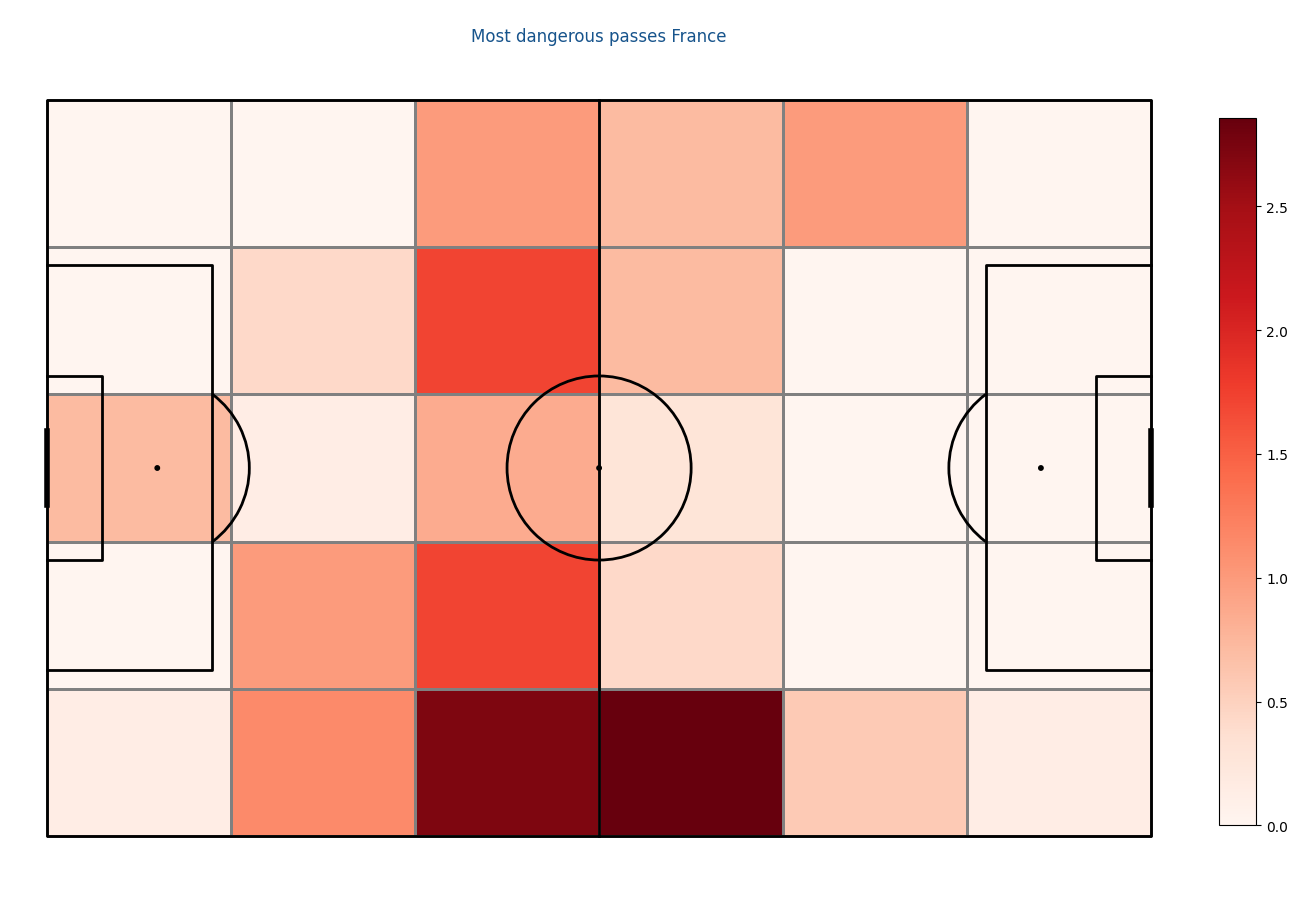

In [35]:
pitch = Pitch(line_color='black',pitch_color='white', stripe = True, line_zorder = 2 )
fig , ax = pitch.grid(grid_height=0.9, title_height=0.06,axis=False,
                     endnote_height=0.04,title_space=0,endnote_space=0)

bin_statistic = pitch.bin_statistic(danger_passes.x,danger_passes.y, statistic='count',bins=(6,5),normalize=False)
bin_statistic['statistic'] = bin_statistic['statistic']/no_games

pcm = pitch.heatmap(bin_statistic, cmap= 'Reds', edgecolor='grey',ax=ax['pitch'])

ax_cbar = fig.add_axes((1,.093,.03,.786))
cbar=plt.colorbar(pcm,cax=ax_cbar)
fig.suptitle("Most dangerous passes "+ team, c='#17548C')
plt.show()